In [23]:
import numpy as np
import tensorflow as tf
print(tf.VERSION)

1.8.0


In [24]:
def id_block(inputs,n_filters,train,lmd):
    conv1 = tf.layers.conv2d(inputs=inputs,filters=n_filters,kernel_size=[3,3],padding='same',name='conv1',kernel_initializer=tf.contrib.layers.variance_scaling_initializer(factor=2.0,mode='FAN_IN',uniform=False),kernel_regularizer=tf.contrib.layers.l2_regularizer(scale=lmd))
    bn1 = tf.layers.batch_normalization(inputs=conv1,training=train,name='bn1')
    relu1 = tf.nn.relu(bn1)
    conv2 = tf.layers.conv2d(inputs=relu1,filters=n_filters,kernel_size=[3,3],padding='same',name='conv2',kernel_initializer=tf.contrib.layers.variance_scaling_initializer(factor=2.0,mode='FAN_IN',uniform=False),kernel_regularizer=tf.contrib.layers.l2_regularizer(scale=lmd))
    bn2 = tf.layers.batch_normalization(inputs=conv2,training=train,name='bn2')
    shortcut = tf.add(inputs,bn2,name='shortcut')
    return tf.nn.relu(shortcut)

In [25]:
def conv_block(inputs,n_filters,train,lmd):
    conv_shortcut = tf.layers.conv2d(inputs=inputs,filters=n_filters,kernel_size=[1,1],strides=[2,2],name='conv_shortcut',kernel_initializer=tf.contrib.layers.variance_scaling_initializer(factor=2.0,mode='FAN_IN',uniform=False),kernel_regularizer=tf.contrib.layers.l2_regularizer(scale=lmd))
    bn_shortcut = tf.layers.batch_normalization(inputs=conv_shortcut,training=train,name='bn_shortcut')
    input_pad = tf.pad(inputs,[[0,0],[1,1],[1,1],[0,0]],mode='CONSTANT')
    conv1 = tf.layers.conv2d(inputs=input_pad,filters=n_filters,kernel_size=[3,3],strides=[2,2],name='conv1',kernel_initializer=tf.contrib.layers.variance_scaling_initializer(factor=2.0,mode='FAN_IN',uniform=False),kernel_regularizer=tf.contrib.layers.l2_regularizer(scale=lmd))
    bn1 = tf.layers.batch_normalization(inputs=conv1,training=train,name='bn1')
    relu1 = tf.nn.relu(bn1)
    conv2 = tf.layers.conv2d(inputs=relu1,filters=n_filters,kernel_size=[3,3],padding='same',name='conv2',kernel_initializer=tf.contrib.layers.variance_scaling_initializer(factor=2.0,mode='FAN_IN',uniform=False),kernel_regularizer=tf.contrib.layers.l2_regularizer(scale=lmd))
    bn2 = tf.layers.batch_normalization(inputs=conv2,training=train,name='bn2')
    shortcut = tf.add(bn_shortcut,bn2,name='shortcut')
    return tf.nn.relu(shortcut)

In [26]:
def resnet_model(features,labels,mode,params):
    idblock_count = 0
    convblock_count = 0
    output = features['x']
    lmd = params['regulariser']
    
    with tf.variable_scope('initial'):
        output = tf.layers.conv2d(inputs=output,filters=params['init_filters'],kernel_size=[3,3],padding='same',name='conv0',kernel_initializer=tf.contrib.layers.variance_scaling_initializer(factor=2.0,mode='FAN_IN',uniform=False),kernel_regularizer=tf.contrib.layers.l2_regularizer(scale=lmd))
        output = tf.layers.batch_normalization(inputs=output,training=(mode==tf.estimator.ModeKeys.TRAIN),name='bn0')
        output = tf.nn.relu(output)
    
    for block,filters in params['net']:
        if block=='id':
            idblock_count += 1
            with tf.variable_scope('id_block' + str(idblock_count)):
                output = id_block(output,filters,(mode==tf.estimator.ModeKeys.TRAIN),lmd)
        else:
            convblock_count += 1
            with tf.variable_scope('conv_block' + str(convblock_count)):
                output = conv_block(output,filters,(mode==tf.estimator.ModeKeys.TRAIN),lmd)
    
    output = tf.layers.average_pooling2d(inputs=output,pool_size=[8,8],strides=1)
    output = tf.reshape(output,[-1,params['flat_size']])
    logits = tf.layers.dense(inputs=output,units=params['n_classes'],activation=None)
    
    predictions = {
        'classes' : tf.argmax(logits,axis=1),
        'probabilities' : tf.nn.softmax(logits)
    }
    
    if mode==tf.estimator.ModeKeys.PREDICT:
        return tf.estimator.EstimatorSpec(predictions=predictions,mode=mode)
    
    loss = tf.losses.sparse_softmax_cross_entropy(labels=labels,logits=logits)
    
    if mode==tf.estimator.ModeKeys.TRAIN:
        global_step = tf.train.get_global_step()
        learning_rate = tf.train.exponential_decay(params['learning_rate'],global_step,params['lr_drop'],0.2,staircase=True)
        optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
        update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
        with tf.control_dependencies(update_ops):
            train_op = optimizer.minimize(loss=loss,global_step=global_step)
        return tf.estimator.EstimatorSpec(loss=loss,mode=mode,train_op=train_op)
    
    eval_ops = {
        'accuracy' : tf.metrics.accuracy(labels=labels,predictions=predictions['classes'])
    }
    
    return tf.estimator.EstimatorSpec(mode=mode,loss=loss,eval_metric_ops=eval_ops)

In [27]:
net_def = [('id',16),
           ('id',16),
           ('id',16),
           ('id',16),
           ('id',16),
           ('id',16),
           ('id',16),
           ('id',16),
           ('id',16),
           ('conv',32),
           ('id',32),
           ('id',32),
           ('id',32),
           ('id',32),
           ('id',32),
           ('id',32),
           ('id',32),
           ('id',32),
           ('id',32),
           ('conv',64),
           ('id',64),
           ('id',64),
           ('id',64),
           ('id',64),
           ('id',64),
           ('id',64),
           ('id',64),
           ('id',64),
           ('id',64)]
params = {
    'net' : net_def,
    'regulariser' : 0.0005,
    'flat_size' : 64,
    'n_classes' : 10,
    'init_filters' : 16,
    'learning_rate' : 0.1,
    'lr_drop' : 4000
}
print(len(params['net']))
resnet = tf.estimator.Estimator(model_fn=resnet_model,params=params,model_dir='RESNET56')

29
INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': 'RESNET56', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f0e3eab0780>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [28]:
(x_train,y_train),(x_test,y_test) = tf.keras.datasets.cifar10.load_data()
x_train = np.asarray(x_train,dtype=np.float32)
x_test = np.asarray(x_test,dtype=np.float32)
y_train = np.asarray(y_train,dtype=np.int32)
y_test = np.asarray(y_test,dtype=np.int32)
mean = np.mean(x_train,axis=(0,1,2,3))
std = np.std(x_train,axis=(0,1,2,3))
x_train = (x_train - mean)/(std + 1e-7)
x_test = (x_test - mean)/(std + 1e-7)

In [22]:
train_input = tf.estimator.inputs.numpy_input_fn(x={'x' : x_train},y=y_train,batch_size=128,num_epochs=None,shuffle=True)
resnet.train(input_fn=train_input,steps=64000)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1 into RESNET56/model.ckpt.
INFO:tensorflow:loss = 3.8711147, step = 0
INFO:tensorflow:global_step/sec: 5.03842
INFO:tensorflow:loss = 2.0600586, step = 100 (19.848 sec)
INFO:tensorflow:global_step/sec: 5.52629
INFO:tensorflow:loss = 2.0029533, step = 200 (18.095 sec)
INFO:tensorflow:global_step/sec: 5.50328
INFO:tensorflow:loss = 1.7931762, step = 300 (18.171 sec)
INFO:tensorflow:global_step/sec: 5.48862
INFO:tensorflow:loss = 1.956333, step = 400 (18.220 sec)
INFO:tensorflow:global_step/sec: 5.47908
INFO:tensorflow:loss = 1.7505488, step = 500 (18.251 sec)
INFO:tensorflow:global_step/sec: 5.48084
INFO:tensorflow:loss = 1.5686349, step = 600 (18.245 sec)
INFO:tensorflow:global_step/sec: 5.46644
INFO:tensorflow:los

KeyboardInterrupt: 

In [29]:
eval_input = tf.estimator.inputs.numpy_input_fn(x={'x' : x_test},y=y_test,num_epochs=1,shuffle=False)
eval_results = resnet.evaluate(input_fn=eval_input)
print(eval_results)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-06-23-20:08:32
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from RESNET56/model.ckpt-19464
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-06-23-20:08:38
INFO:tensorflow:Saving dict for global step 19464: accuracy = 0.7702, global_step = 19464, loss = 1.8431383
{'accuracy': 0.7702, 'loss': 1.8431383, 'global_step': 19464}


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: `toimage` is deprecated!
`toimage` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use Pillow's ``Image.fromarray`` directly instead.
  


ValueError: Could not find trained model in model_dir: /tmp/tmplerdx27b.

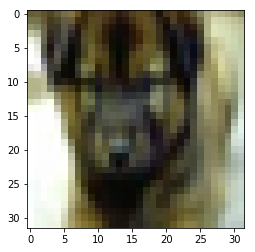

In [10]:
import matplotlib.pyplot as plt
from random import randint
from scipy.misc import toimage
num = randint(0,10000-1)
classes = ['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']
plt.imshow(toimage(x_test[num] * (std + 1e-7) + mean))
img = np.reshape(x_test[num],(1,32,32,3))
pred_fn = tf.estimator.inputs.numpy_input_fn({'x' : img},shuffle=False)
pred_res = resnet.predict(input_fn=pred_fn)
result = next(pred_res)['classes']
print(classes[result])
if result == y_test[num]:
    print('Classification is accurate')
else:
    print('Classification is inaccurate')